In [1]:
import os
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import scipy.cluster.hierarchy as hcluster
from sklearn.cluster import KMeans

from baseimage import PETImage, CTImage, normalize

figsize = (8,6)

# put filepath to image to open
filepath = os.path.join("single_mouse_pet",
# 						"mpet3715b_em1_v1.pet.img")
 						"mpet3721a_em1_v1_s4.pet.img")


In [2]:
img = PETImage(filepath=filepath)
img.load_image()

File dimensions: (128,128,159,40)
Reading image data...


In [3]:
# print(img.img_data.shape)
type(img) is PETImage
ix = [(2,6),(4,9),(1,100)]
img.img_data[ix].shape

(2, 40)

In [4]:
# get one voxel
I = img.img_data[80,64,64,:]
I=I/I.sum()
T = np.linspace(1,40,40)

##### Fit polynomials to voxel intensity over time

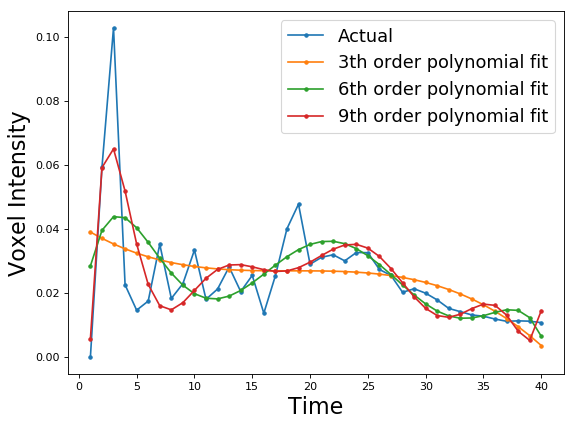

In [5]:
# polynomial fitting

fig=plt.figure(figsize=figsize, dpi= 80, facecolor='w', edgecolor='k')
ORDER = 5
plt.plot(np.linspace(1,40,40), I,'.-')
orders = [3,6,9]
for k in orders:
    coeffs = np.polyfit(T,I,k)
    Ih = np.poly1d(coeffs)
    plt.plot(T,Ih(T),'.-')
    
plt.xlabel('Time',fontsize=20)
plt.ylabel('Voxel Intensity',fontsize=20)
plt.legend(['Actual']+['{}th order polynomial fit'.format(k) for k in orders],fontsize=16)


In [7]:
# guessing mouse roi
Ns = img.img_data.shape
Ws = (60,40,40)
v = [(int((N-W)/2),int((N+W)/2)) for N,W in zip(Ns,Ws)]
ROI = img.img_data[v[0][0]:v[0][1],v[1][0]:v[1][1],v[2][0]:v[2][1],:]


# Time Series PCA voxel by voxel

Text(0,0.5,'Voxel Intensity')

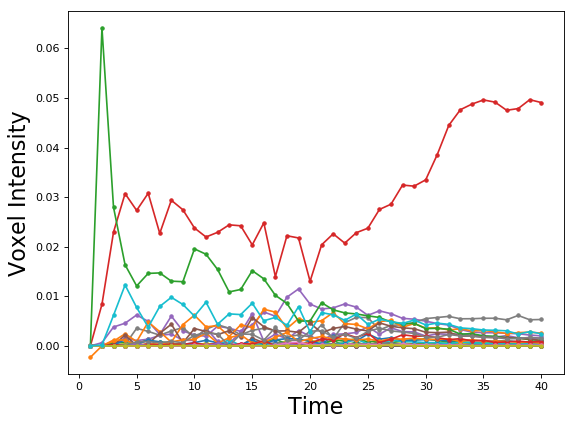

In [8]:
# plot many vox over time
X = ROI.reshape(60*40*40,40)
X = X/(np.sum(np.abs(X)**2,axis=0)**(1./2))[None,:]
fig=plt.figure(figsize=figsize, dpi= 80, facecolor='w', edgecolor='k')
for k in [np.random.randint(1,60*40*40) for _ in range(40)]:
    pix = X[k,:]
    t = np.linspace(1,40,40)
    plt.plot(t,pix,'.-')
plt.xlabel('Time',fontsize=20)
plt.ylabel('Voxel Intensity',fontsize=20)

##### Project raw intensity time series onto ROI SVD eigenvectors

Text(0,0.5,'x dot eigvec2')

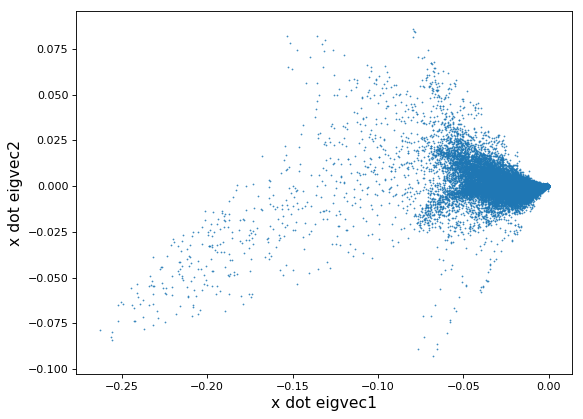

In [9]:
# project onto 2 columns in U
U, S, Vh = np.linalg.svd(X.T.dot(X))

fig=plt.figure(figsize=figsize, dpi= 80, facecolor='w', edgecolor='k')
basis = U[:,0:2].T
basis.shape
proj = basis.dot(X.T)
plt.scatter(proj[0,:],proj[1,:],s=1,marker='.')
plt.xlabel('x dot eigvec1',fontsize=14)
plt.ylabel('x dot eigvec2',fontsize=14)

##### Cluster (manually) based off above plot and show mask

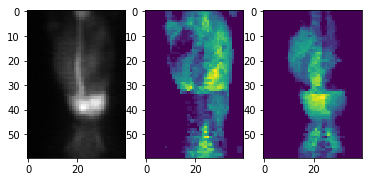

In [10]:
eps = .01
third_quadr = lambda x: (x[0]<0 and x[1]<0 and np.linalg.norm(x) > eps)
is_third_quadr = np.apply_along_axis(third_quadr,0,proj)
is_third_quadr = is_third_quadr.reshape(60,40,40)

second_quadr = lambda x: (x[0]<0 and x[1]>0 and np.linalg.norm(x) > eps)
is_second_quadr = np.apply_along_axis(second_quadr,0,proj)
is_second_quadr = is_second_quadr.reshape(60,40,40)

# view selected points on ROI
view_ax = 'y'


view_ax = img.get_axis(view_ax)
t_ax = img.get_axis('t')

mask_collapse = np.sum

roi_image = normalize(ROI.max(axis=t_ax).sum(axis=view_ax))
third_quadr_mask = np.apply_along_axis(mask_collapse,view_ax,is_third_quadr).astype(int)
second_quadr_mask = np.apply_along_axis(mask_collapse,view_ax,is_second_quadr).astype(int)

f, axes = plt.subplots(1, 3)


plt.rcParams["figure.figsize"] = (30,40)
axes[0].imshow(roi_image, cmap="gray",clim=(0,1))
axes[1].imshow(third_quadr_mask)
axes[2].imshow(second_quadr_mask)

## More features and better clustering...

##### Set N features and project into transformed space

In [17]:
# transform into eigenbasis
n_features = 8
X_h = U[:,:n_features].T.dot(X.T)



##### Apply Kmeans clustering to transformed data points (set N clusters to find)

In [18]:
N=60*40*40
nclusters = 12
roi_frame = ROI.max(axis=t_ax)

# indicate whether to use roi vals in mask; False => mask is 3D 0 or 1 boolean
use_roi_vals = False

# cluster transformed data
kmeans = KMeans(init='k-means++', n_clusters=nclusters, n_init=20)
kmeans.fit(X_h.T)
Z = kmeans.predict(X_h.T)

# a skeleton array from which to build the masks
root_mask = np.linspace(0,N-1,N)
 
# build masks
masks = []
for c in set(Z):
    maskfun = np.vectorize(lambda x: int(Z[int(x)]==c))
    mask = maskfun(root_mask).reshape(60,40,40)
    mask = np.multiply(roi_frame,mask) if use_roi_vals else mask
    masks.append(mask)
    

print('Created {} masks of image'.format(len(masks)))

Created 12 masks of image


##### Create segmentation and compare to original ROI Image

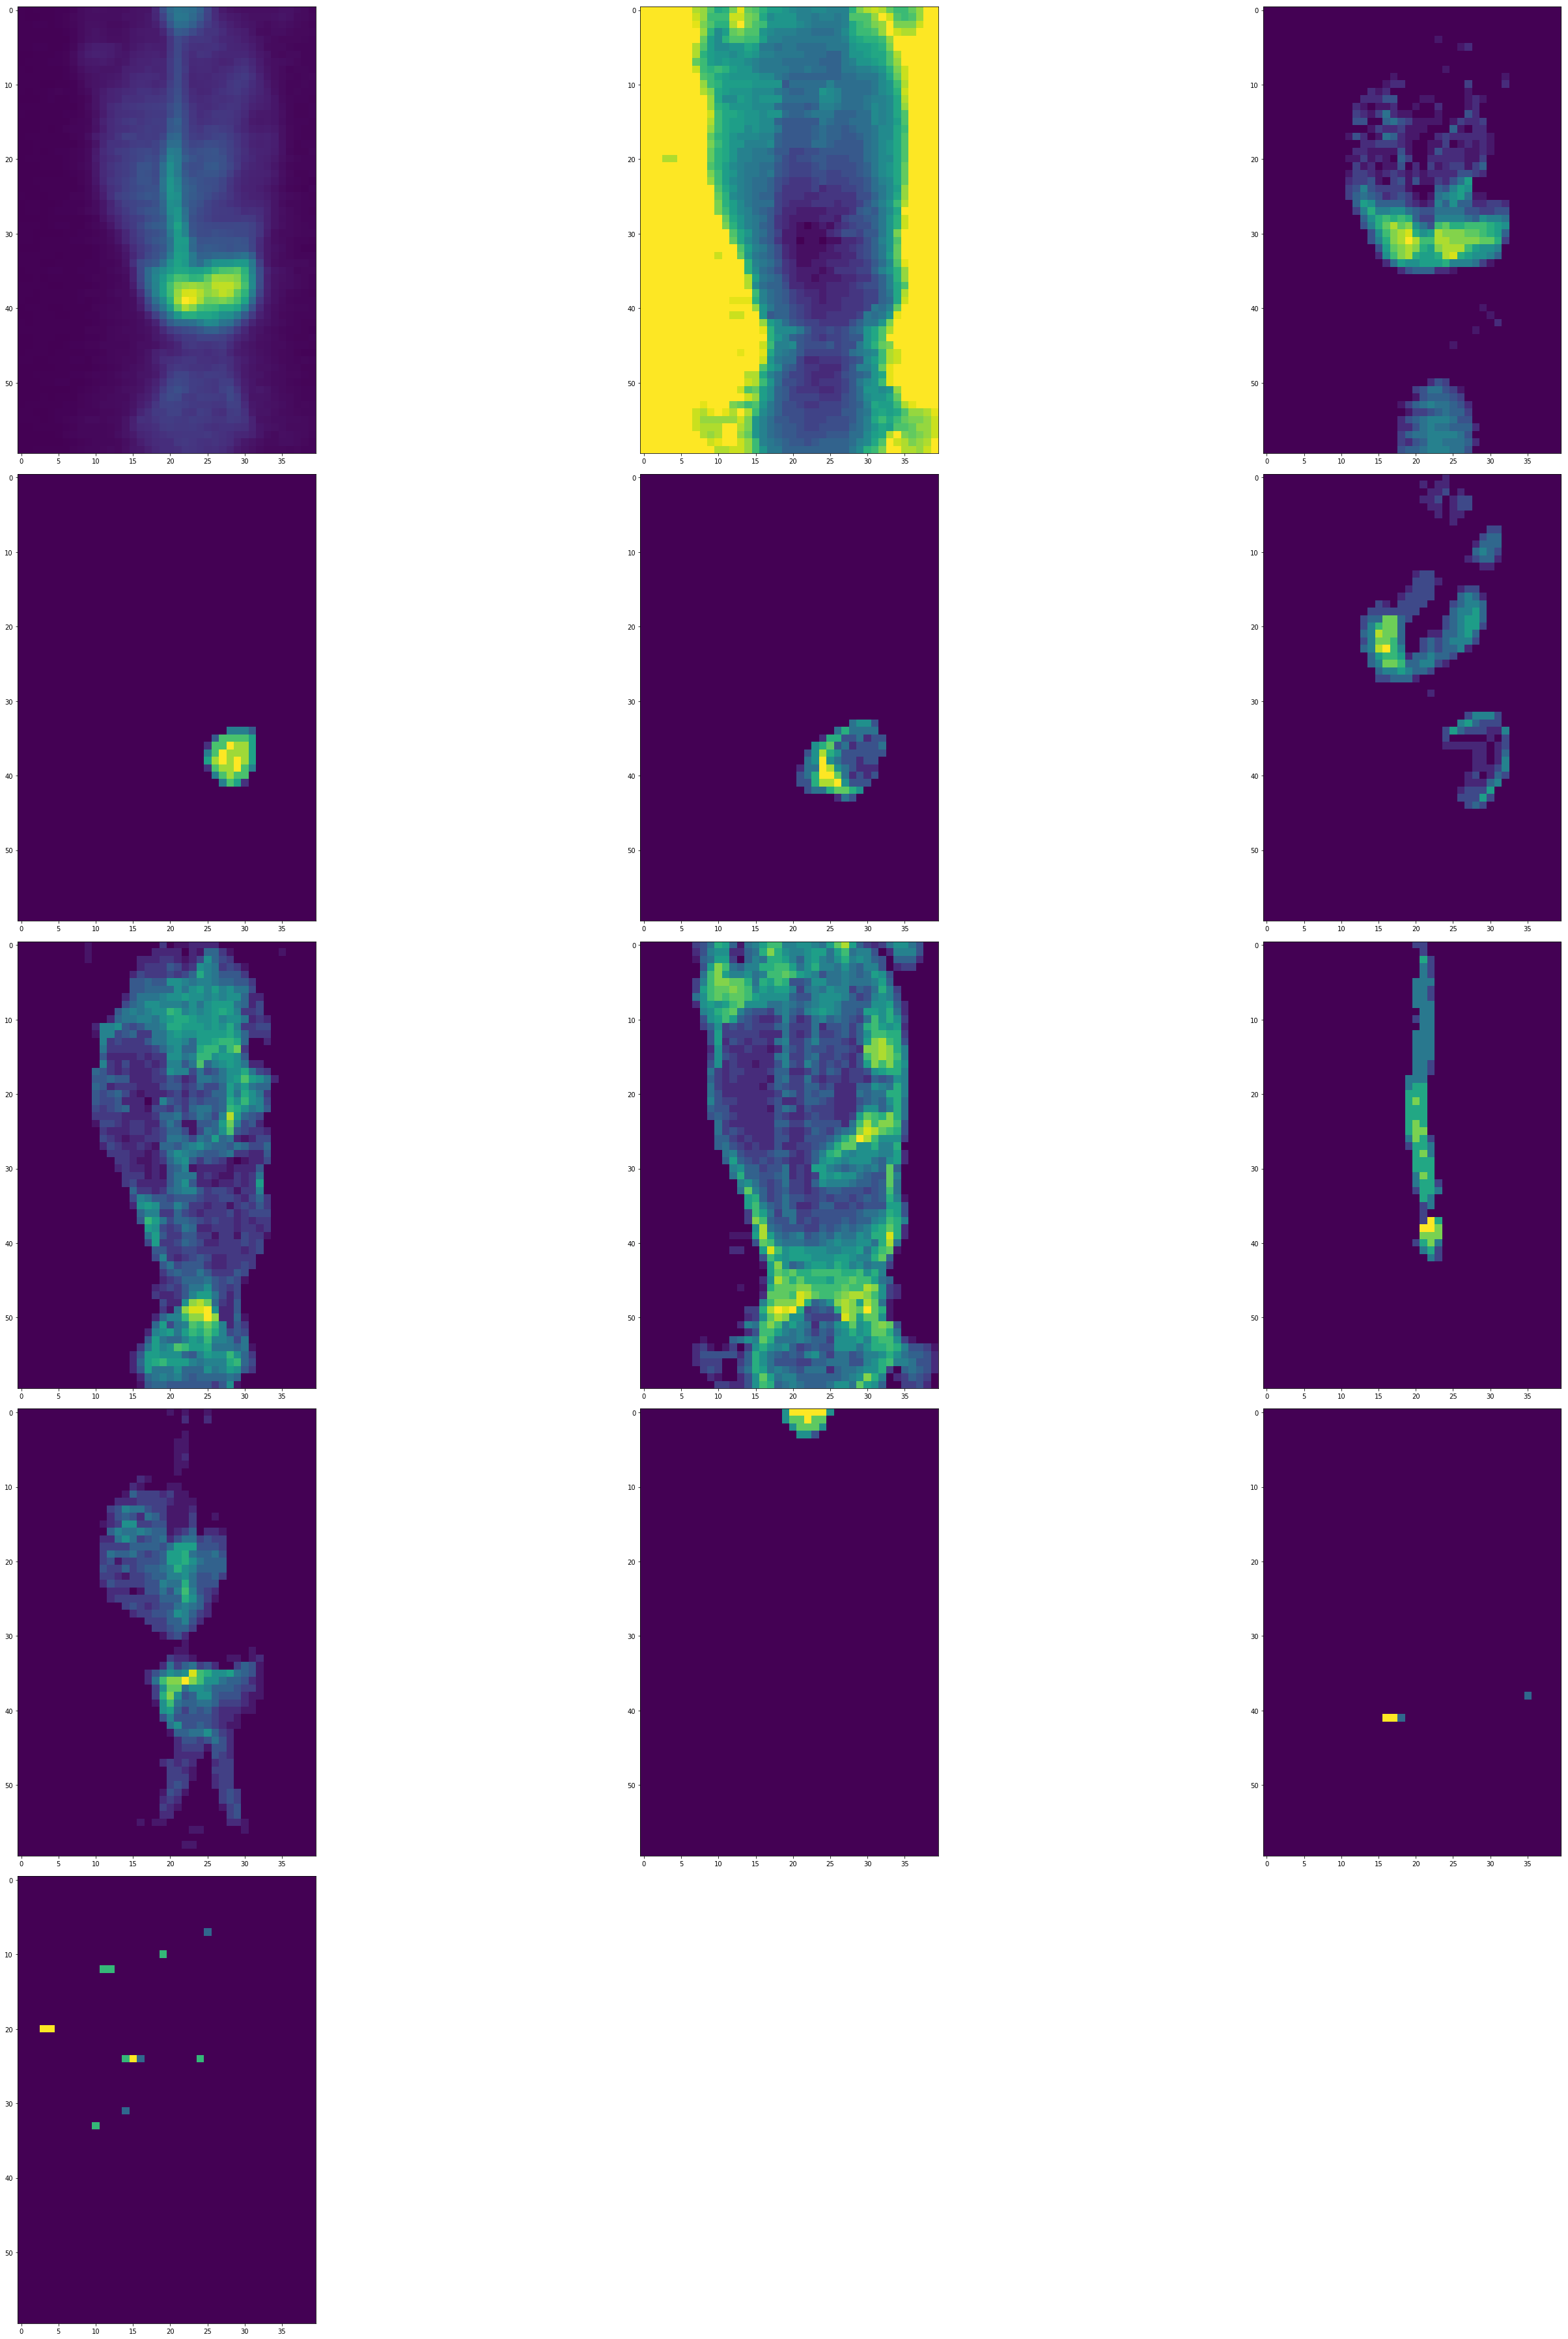

In [19]:
# axis to view segmentations
view_ax = 'y'

# how to collapse the mask into 2D; usually use {any, or np.sum}
mask_collapse = np.sum

view_ax = img.get_axis(view_ax)
t_ax = img.get_axis('t')



fig = plt.figure()
axes = []
nplots = len(masks)+1
for k in range(nplots):
    ax = fig.add_subplot(1+nplots//3,3,k+1)
    axes.append(ax)

plt.rcParams["figure.figsize"] = (40,50)
roi_mat = roi_frame.sum(axis=view_ax)
roivs = (roi_mat.flatten().min(), roi_mat.flatten().max())
# plot original image
roi_image = roi_mat
axes[0].imshow(roi_image,clim=roivs)

roivs = roivs if use_roi_vals else ()
for ax,premask in zip(axes[1:],masks):
    fmask = np.apply_along_axis(mask_collapse,view_ax,premask)
    kwargs = {'clim':roivs} if use_roi_vals else {}
    ax.imshow(fmask,**kwargs)
plt.tight_layout()

### Polynomial fitting PCA

In [232]:
# transform into nth order polynomial
order = 5
t = np.linspace(1,40,40)
N = X.shape[0]
print('Fitting {} points'.format(N))
COEFFS = np.ndarray((N,order+1))
for k in range(N):
    vox = X[k,:]
    COEFFS[k,:] = np.polyfit(t,vox,order)

    

Fitting 96000 points


In [279]:
# do SVD in polynomial coefficient space
Up, Sp, Vhp = np.linalg.svd(COEFFS.T.dot(COEFFS))
Up.shape
img.get_axis('y')

1

##### 2D projection onto top (2) SVD Eigenvectors

(-0.045, 0.06)

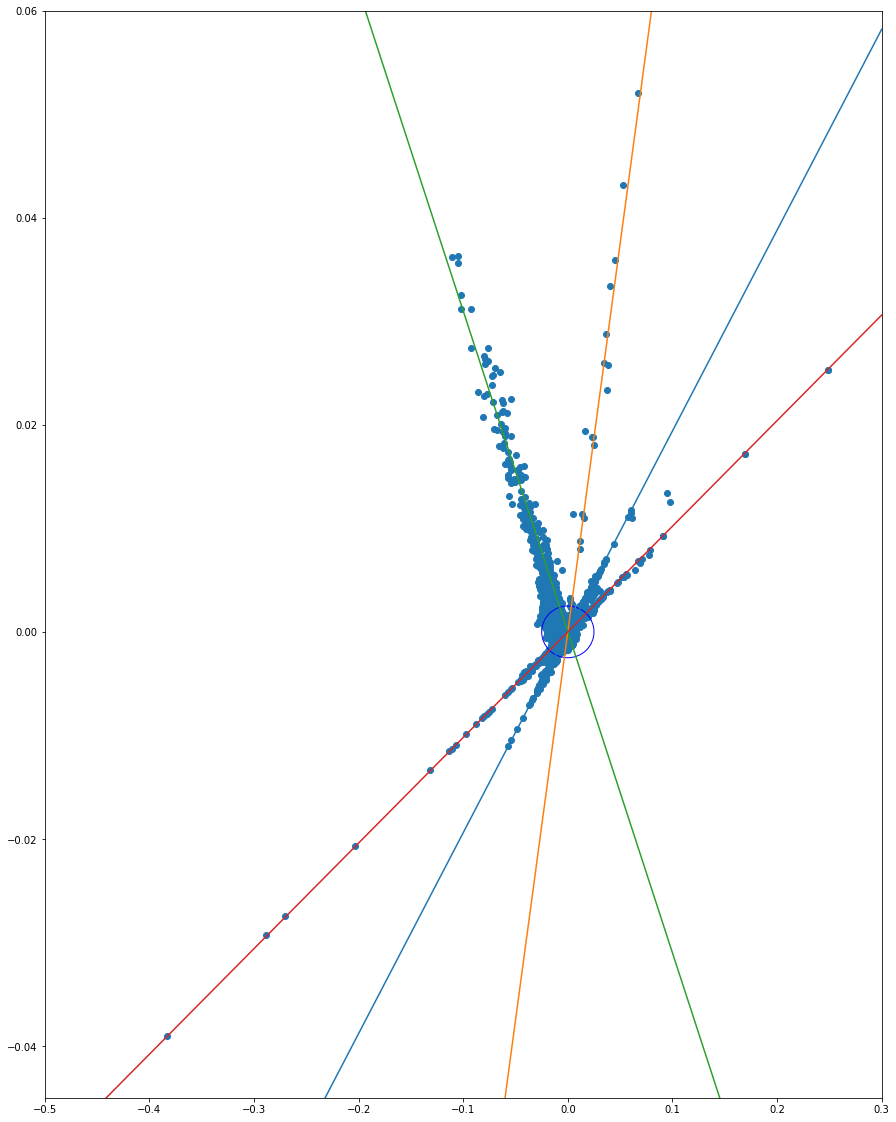

In [234]:

%matplotlib inline  
# open figure in new window

# plot projection onto two greatest PCs
plt.rcParams["figure.figsize"] = (15,20)
fig,ax=plt.subplots()

basis = Up[:,0:2].T
projc = basis.dot(COEFFS.T)
plt.scatter(projc[0,:],projc[1,:])


# find some lines
la,lb = -.5,.3

slope = .194
x_vals = np.linspace(la,lb,3)
y_vals = slope*x_vals
plt.plot(x_vals, y_vals, '-')

slope = .75
x_vals = np.linspace(la,lb,3)
y_vals = slope*x_vals
plt.plot(x_vals, y_vals, '-')

slope = -.31
x_vals = np.linspace(la,lb,3)
y_vals = slope*x_vals
plt.plot(x_vals, y_vals, '-')

slope = .102
x_vals = np.linspace(la,lb,3)
y_vals = slope*x_vals
plt.plot(x_vals, y_vals, '-')

elip = matplotlib.patches.Ellipse((0,0), 0.05, .005, angle=0, color='b', fill=False)
ax.add_artist(elip)

plt.xlim(-.5,.3)
plt.ylim(-.045,.06)

##### 3D projection onto top (3) SVD Eigenvectors

In [235]:
def point_line_dist(x,m):
    # assumes ax1-x2=0
    return abs(m*x[0]-x[1])/np.sqrt(m**2+1)

def ellipse_norm(x,a=.05,b=.005):
    return np.sqrt(x[0]**2/a + x[1]**2/b)

def ellipse_ptl_dist(x,m,a=.05,b=.005):
    # point to line distance using ellipse-based norm
    return abs(m*x[0]/np.sqrt(a)-x[1]/np.sqrt(b))/np.sqrt(m**2/a+1/b)

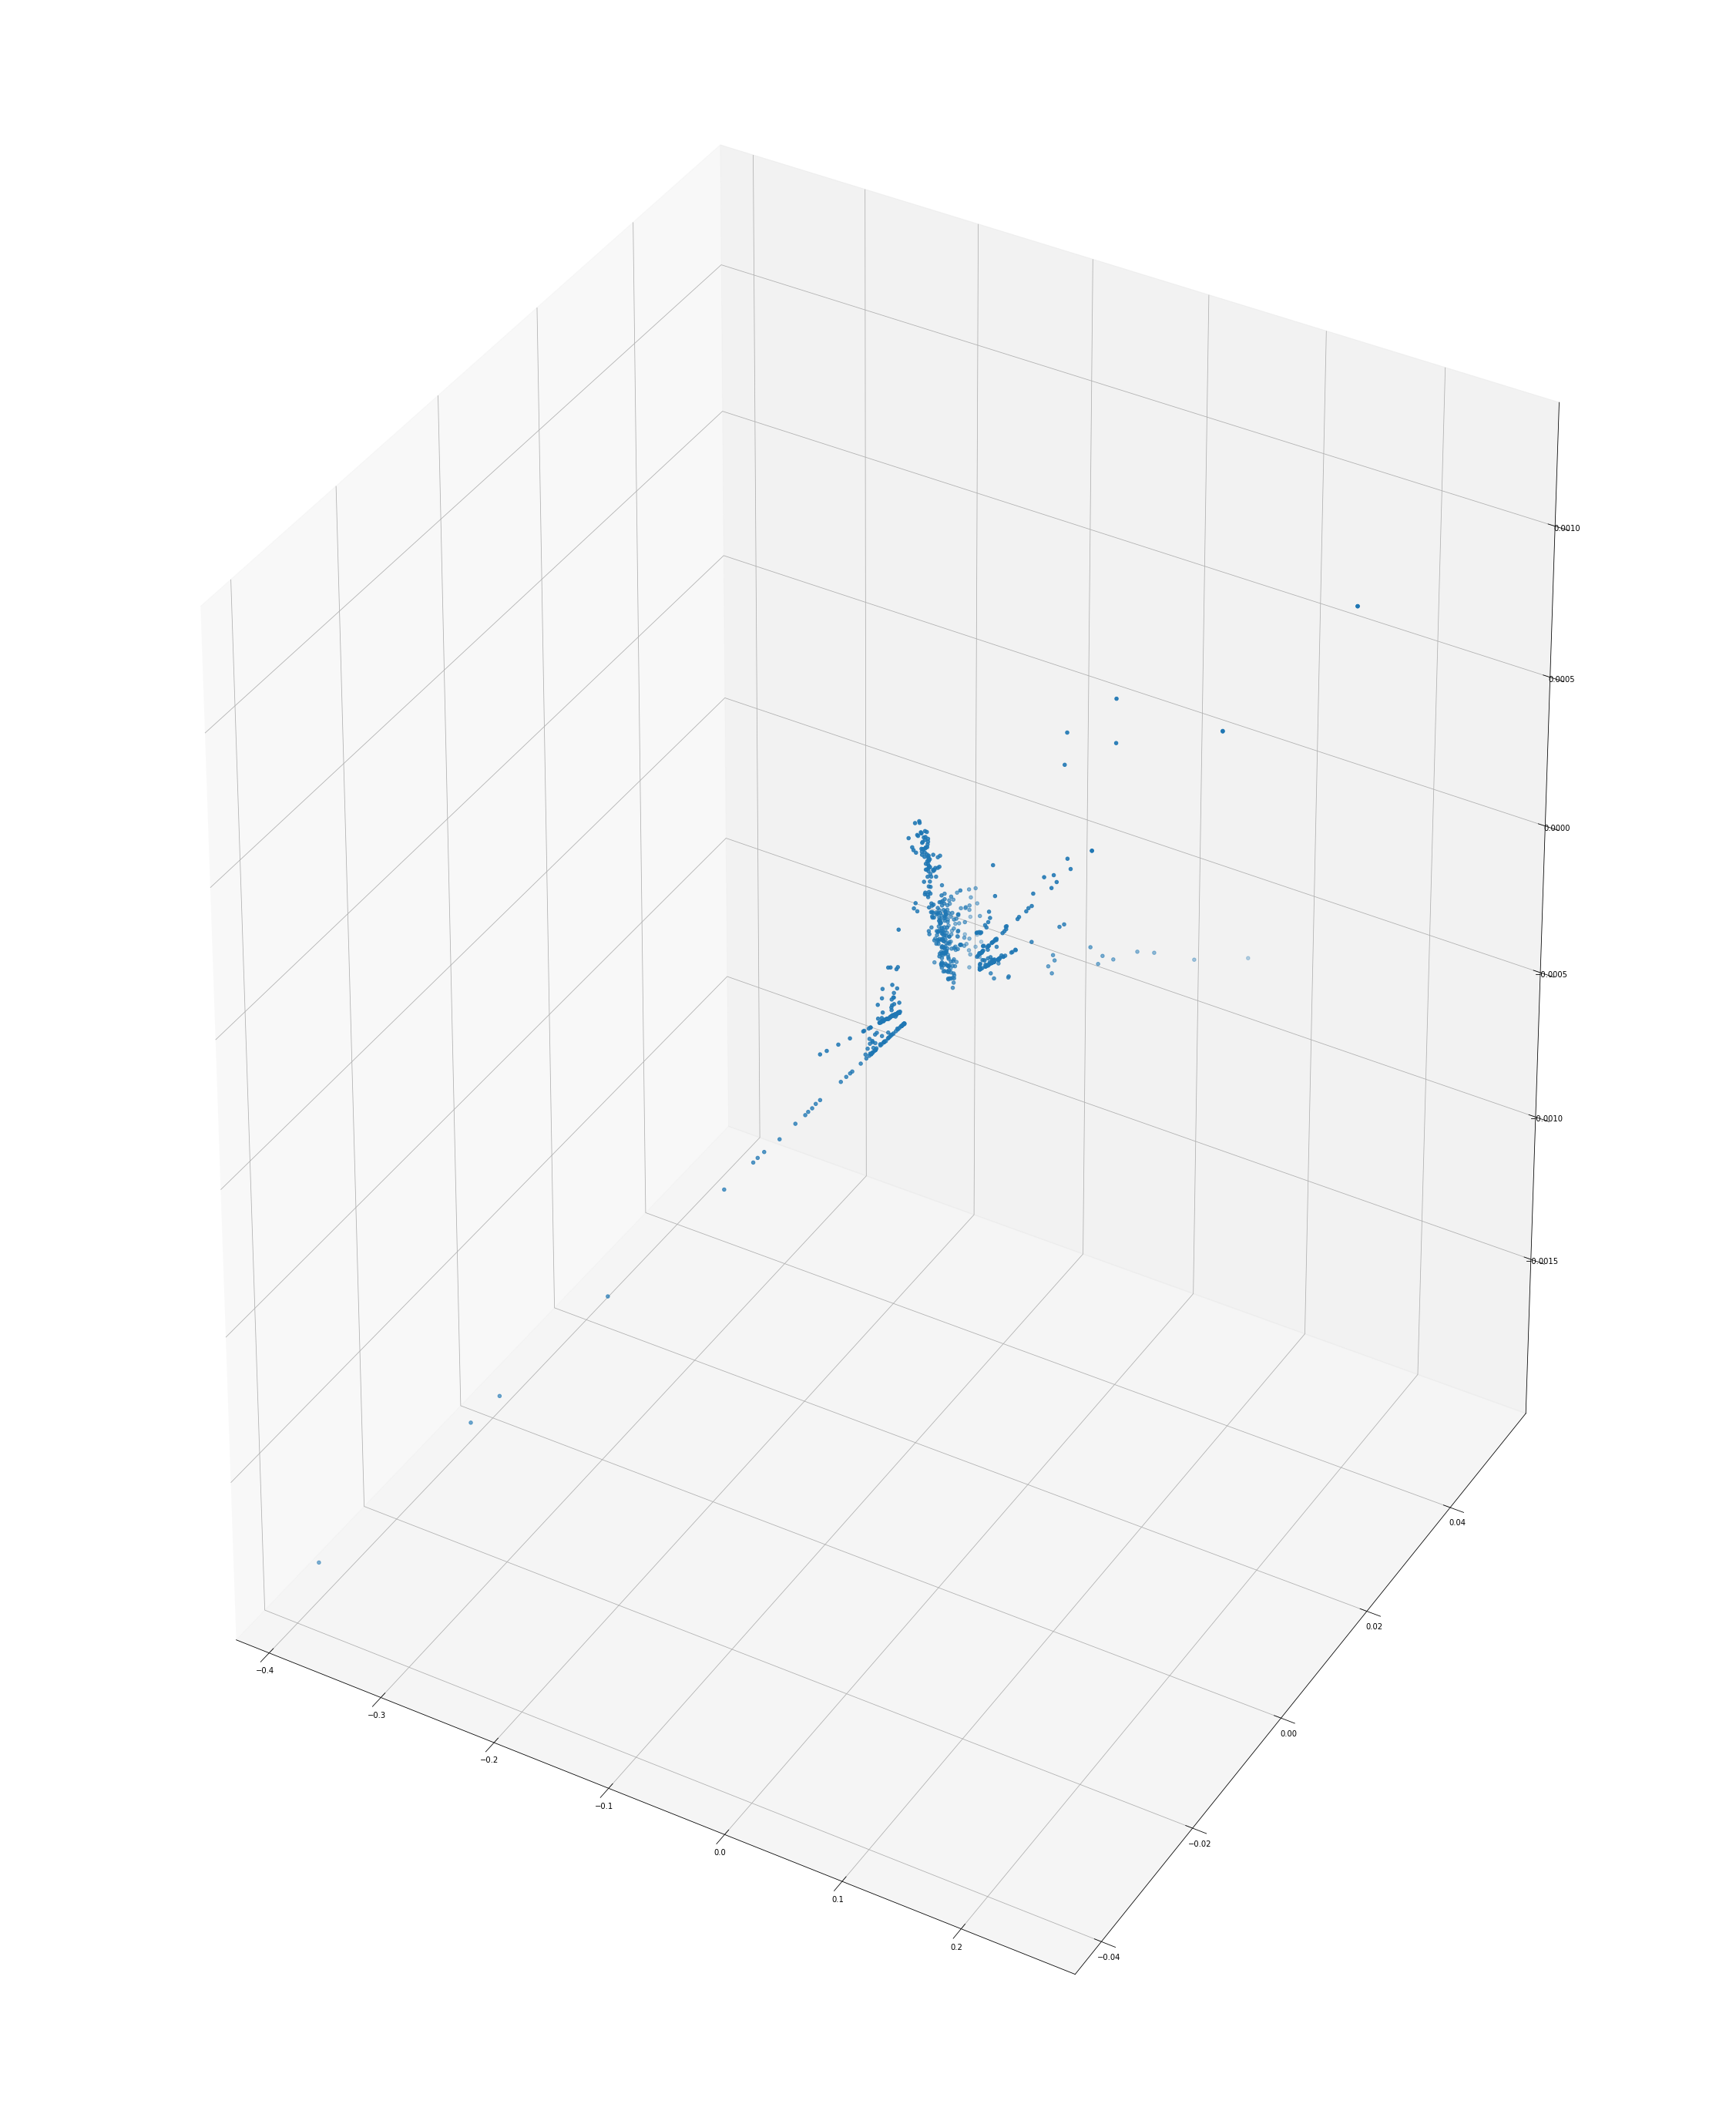

In [236]:
# open figure in new window

%matplotlib qt


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# plot projection onto two greatest PCs
plt.rcParams["figure.figsize"] = (15,20)

basis = Up[:,[0,1,2]].T
projc3 = basis.dot(COEFFS.T)

# just select some w/ at least some norm
selection = np.apply_along_axis(lambda x:ellipse_norm(x)>.1,0,projc3)
projc3_selct = projc3[:,selection]

ax.scatter(projc3_selct[0,:],projc3_selct[1,:],projc3_selct[2,:])


##### Cluster in Eigenspace using point-to-line distance and ellipse norm cutoff

305
376
148


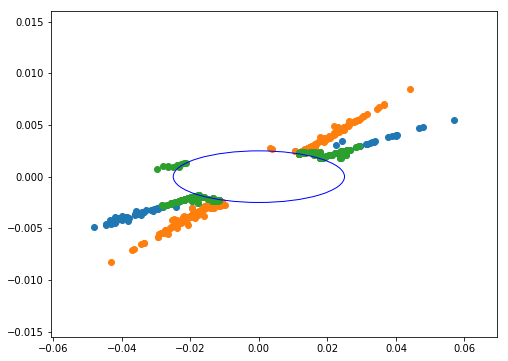

In [237]:
# open figure in notebook
%matplotlib inline
plt.rcParams["figure.figsize"] = figsize

# find sets show on image
fig,ax=plt.subplots()

# the set in the 2nd quadrant as seen in above graph
# corresponds to line with negative slope
eps = .02
snd = lambda x: (x[0]<0 and x[1]>0 and ellipse_norm(x,.05,.005) > eps)
is_snd = np.apply_along_axis(snd,0,projc)
is_snd = is_snd.reshape(60,40,40)

# should do clustering here?
pl_eps = .002
norm_eps = .5
slopes = [.194, .75, .102]
other_masks = []
for a in slopes:
    is_on_line = lambda x: (ellipse_ptl_dist(x,a)<pl_eps and ellipse_norm(x,.05**2,.005**2)>norm_eps)
    on_line = np.apply_along_axis(is_on_line,0,projc)
    on_line = on_line.reshape(60,40,40)
    other_masks.append(on_line)
    
    s = [projc[:,i] for i in range(N) if is_on_line(projc[:,i])]
    plt.scatter(*zip(*s))
    print(len([d for d in on_line.flatten() if d]))
    
    
# plot same ellipse for reference
elip = matplotlib.patches.Ellipse((0,0), 0.05, .005, angle=0, color='b', fill=False)
ax.add_artist(elip)



# isnd = np.argwhere(is_snd)

# for k in range(N):
#     v = projc[:,k]
#     if v[0] < 0 and v[1] > 0:
        

##### View masks on ROI;  only first mask looks interesting;  try using clustering with more eigenvectors

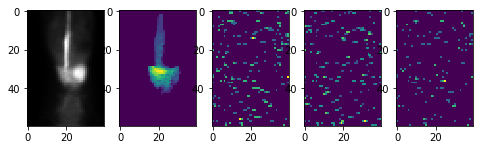

In [238]:
# view selected points on ROI
view_ax = 'y'


view_ax = img.get_axis(view_ax)
t_ax = img.get_axis('t')

mask_collapse = np.sum


roi_image = normalize(ROI.max(axis=t_ax).sum(axis=view_ax))
mask = np.apply_along_axis(mask_collapse,view_ax,is_snd).astype(int)

f, axes = plt.subplots(1, 5)



plt.rcParams["figure.figsize"] = (15,20)
axes[0].imshow(roi_image, cmap="gray",clim=(0,1))
axes[1].imshow(mask)
for ax,premask in zip(axes[2:],other_masks):
    fmask = np.apply_along_axis(mask_collapse,view_ax,premask).astype(int)
    ax.imshow(fmask)

# Scratchwork

In [ ]:
# filter data with low L1 norm in new basis
reg = lambda x: np.linalg.norm(x,ord=1)
eps = .02
select_ix = np.argwhere(np.apply_along_axis(lambda x: reg(x)>eps,0,X_h))      # select indices to cluster
non_select_ix = np.argwhere(np.apply_along_axis(lambda x: reg(x)<=eps,0,X_h)) # not efficient way to find compliment of select_ix
X_h_select = X_h[:,select_ix]

# normalize vectors that passed eps threshold long enough
X_h_select = np.apply_along_axis(lambda x:x/np.linalg.norm(x),0,X_h_select)
X_h_select = np.squeeze(X_h_select)

In [209]:
np.apply_along_axis(any,iax,is_snd).shape

(60, 40)

In [344]:
a1 = np.argwhere(other_masks[0])
a2 = np.argwhere(other_masks[1])
print(len([p for p in a1 if p in a2]))
print(len(np.argwhere(is_snd)))

2852
1370


In [352]:
projc[np.argwhere(on_line)]

IndexError: index 9 is out of bounds for axis 0 with size 2

In [384]:
k = np.linspace(1,2,2)

In [387]:
ellipse_norm(k,.5,.5)

ValueError: shapes (2,) and (1,2) not aligned: 2 (dim 0) != 1 (dim 0)

In [289]:
X = X/(np.sum(np.abs(X)**2,axis=0)**(1./2))[None,:]
np.sum(np.abs(X)**2,axis=0)**(1./2)
np.apply_along_axis(lambda x: x/np.linalg.norm(x),0,X) - X/(np.sum(np.abs(X)**2,axis=0)**(1./2))[None,:]

array([[ 2.66815378e-20, -1.35585468e-31, -8.13151629e-20, ...,
        -1.82641479e-21, -1.03761536e-20, -1.61465656e-21],
       [ 2.58345049e-20, -1.40207700e-31, -6.24686799e-21, ...,
        -5.34689548e-21, -3.07049443e-21, -4.96308368e-22],
       [-3.29175879e-26, -1.44829932e-31, -3.88774888e-23, ...,
        -6.14098887e-21, -1.38966343e-21, -1.16467030e-21],
       ...,
       [-6.45200878e-23, -9.29834399e-40, -1.86347248e-20, ...,
        -1.50348348e-20, -1.28749008e-19, -2.84550131e-22],
       [-4.48072994e-28, -9.29834399e-40, -6.45862622e-21, ...,
        -4.36751363e-22, -2.92226367e-20, -1.88597180e-22],
       [-3.11808317e-25, -9.29834399e-40, -1.28749008e-19, ...,
        -2.08449514e-22, -2.48815928e-21, -1.65436123e-23]])

In [292]:
def test(a,**kwargs):
    print(a)
    print(kwargs)
    print(type(kwargs))
    tat = kwargs['foo'] if 'foo' in kwargs.keys() else 'nope'
    print(tat)

In [298]:
test('dsfl',loo=320230)

dsfl
{'loo': 320230}
<class 'dict'>
nope


In [297]:
print('yes') if True

SyntaxError: invalid syntax (<ipython-input-297-76cc29e69d24>, line 1)

In [54]:
a = np.arange(12).reshape(3,4)
b = np.arange(12).reshape(3,4)*12

In [55]:
a

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

In [56]:
b

array([[  0,  12,  24,  36],
       [ 48,  60,  72,  84],
       [ 96, 108, 120, 132]])

In [57]:
np.multiply(a,b)

array([[   0,   12,   48,  108],
       [ 192,  300,  432,  588],
       [ 768,  972, 1200, 1452]])